In [402]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, MeanShift, estimate_bandwidth
from scipy.spatial.distance import pdist, squareform
from scipy.stats import iqr
import os

In [403]:
# img_id = '141_nir_2014-07-04'
ind = 3
label = 'yes'

# filein = '../data/fields_raw_' + label + '_good/' + img_id + '.png'

label_out = 1 if label=='yes' else 0

# directory = '../data/fields_raw_' + label + '/'
directory = '../data/fields_raw_' + label + '_good/'

filein = directory + os.listdir(directory)[ind]

# img_id = '125_nir_2016-08-18'

# filein = '../data/fields_raw_no/' + img_id + '.png'

In [404]:
filein

'../data/fields_raw_yes_good/113_nir_2014-08-09.png'

In [405]:
# Load raw image, convert to grayscale
img = cv2.imread(filein)
gray_raw = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [406]:
# Normalized
edge = 0
b, t = np.nanpercentile(gray_raw, [edge, 100 - edge])
gray_norm = 255*(gray_raw - b) / (t - b)

In [407]:
# Crop
length = gray_raw.shape[0]
width = gray_raw.shape[1]

frac = 0.05
x1 = int(frac*length)
x2 = length - int(frac*length)
y1 = int(frac*width)
y2 = width - int(frac*width)

cropped = gray_raw[x1:x2,y1:y2]

gray_raw = cropped

In [408]:
# Saturate scale based on percentiles
gray_nonzr = np.ravel(gray_raw[np.where(gray_raw!=np.min(gray_raw))])
gray_vec = np.ravel(gray_nonzr)

edge = 5  # percent
b, t = np.percentile(gray_vec, [edge, 100 - edge])

gray_sat = gray_raw.copy()
gray_sat[np.where(gray_sat<b)] = b
gray_sat[np.where(gray_sat>t)] = t

In [409]:
# Gaussian blur
blur = cv2.GaussianBlur(gray_sat,(3,3),0)

In [410]:
# Adaptive thresholding on saturated + Gaussian blur
thr_ad_blur = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,0)

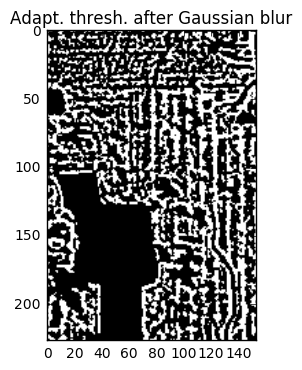

In [411]:
plt.imshow(thr_ad_blur,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Adapt. thresh. after Gaussian blur')
plt.show()

In [412]:
# Calculate length of diagonal
diag = np.sqrt(thr_ad_blur.shape[0]**2+thr_ad_blur.shape[1]**2)
diag

273.74805935385189

In [413]:
# Probabilistic Hough transform (detects line segments)

minLineLength = 20
maxLineGap = 1
lines_pr = cv2.HoughLinesP(thr_ad_blur,1,np.pi/180,10,minLineLength,maxLineGap)
# lines_pr = cv2.HoughLinesP(edges_ad_thr,1,np.pi/180,50,minLineLength,maxLineGap)
len(lines_pr)

2315

In [414]:
# Get angles and lengths
thetas_pr = []
lengths_pr = []
for line in lines_pr.squeeze():
    x1 = line[0]
    y1 = line[1]
    x2 = line[2]
    y2 = line[3]
    theta = np.arctan2(y2-y1,x2-x1)*180/ np.pi
    thetas_pr.append(theta)
    length = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    lengths_pr.append(length)
thetas_pr = np.array(thetas_pr)
lengths_pr = np.array(lengths_pr)
# lengths_pr = np.array(lengths_pr)/diag


In [415]:
# feature for detecting if image contains patterns at all: 
# spread in angle in line segments with similar length
thetas_pr_rad = thetas_pr
thetas_pr = np.abs(thetas_pr)


In [416]:
# k-means clustering
# feat = np.array([thetas_pr,lengths_pr]).T
feat = np.array([lengths_pr]).T
# feat = np.array([lengths_pr]).T/diag
kmeans = KMeans(n_clusters=2).fit(feat)
labels = kmeans.labels_

# db = DBSCAN(eps=0.5, min_samples=5).fit(feat)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
# labels = db.labels_

# bandwidth = estimate_bandwidth(feat, quantile=0.2, n_samples=10)
# ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
# ms.fit(feat)
# labels = ms.labels_
# cluster_centers = ms.cluster_centers_

# labels_unique = np.unique(labels)
# n_clusters_ = len(labels_unique)

# print("number of estimated clusters : %d" % n_clusters_)

In [417]:
# unique_labels = set(labels)
# colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

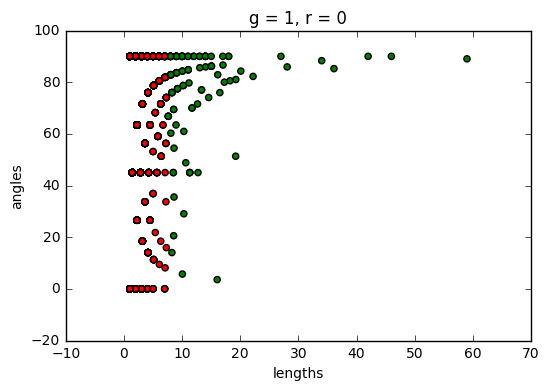

In [418]:
colors = ['g' if label else 'r' for label in labels]

plt.scatter(lengths_pr,thetas_pr,c=colors)
plt.xlabel('lengths')
plt.ylabel('angles')
plt.title('g = 1, r = 0')

plt.show()

In [432]:
top10 = np.percentile(lengths_pr,99)
print top10

iqrangle_top10 = iqr(thetas_pr[lengths_pr>=top10])

print iqrangle_top10

14.938430769
8.06703116754


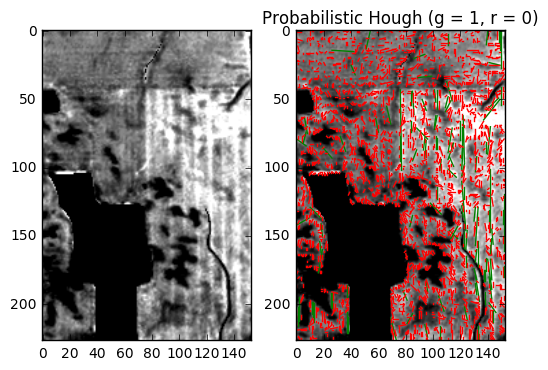

In [420]:
plt.subplot(121)
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))

plt.subplot(122)
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plt.title('Probabilistic Hough (g = 1, r = 0)')
for line_idx in range(len(lines_pr)):
    line = lines_pr[line_idx][0]
    plt.plot([line[0],line[2]],[line[1],line[3]],c=colors[line_idx])
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)
plt.show()

In [421]:
np.max(lengths_pr)

59.008473967727717

In [422]:
lengths_pr[lengths_pr==np.max(lengths_pr)]

array([ 59.00847397])

In [423]:
# find cluster id that has the max length
good = labels[lengths_pr==np.max(lengths_pr)][0]
good

1

In [424]:
# DONT USE IF GOOD CLUSTER IS VERY SMALL

In [425]:
ix  = np.where(labels==good)
cluster_size = len(labels[ix])

In [428]:

avglength  = np.mean(lengths_pr[ix])

stdangle  = np.std(thetas_pr[ix])

medlength =  np.median(lengths_pr[ix])

iqrangle  = iqr(thetas_pr[ix])

# print (cluster_size,avglength,medlength,stdangle,iqrangle)
print (cluster_size,medlength,iqrangle,iqrangle_top10)
# print (cluster_size,medlength/diag,iqrangle)
    


(112, 10.123957324153229, 14.036243467926468, 15.945395900922847)


In [427]:
# POTENTIALLY BETTER FEATURES: 
# - VARIANCE OF ANGLE OF TOP 10% LONG LINES
# - avg length normalized by diagonal
# - 